# Inference: parameter estimation with UQpy

In parameter estimation, one wants to evaluate the parameters that characterize a system from data. It is assumed that the user has perfect knowledge of the input excitation and has access to noisy measurements of the system's displacement (5% rms gaussian measurement noise). This noisy data is generated synthetically using the Bouc-Wen model of hysteresis with non-zero viscous damping as the true model. The model assumed during inference is a Bouc-Wen model of hysteresis without viscous damping, thus introducing some modeling error. The data was generated by running the following line of code: <br>
data_noisy = generate_synthetic_data(scale=scale, params=true_params, namefile=data_file)

Since the estimation procedure takes some time to run, results of the parameter estimation analysis were saved in a file (see results_file). In the following cells, the code necessary to run the estimation and save the results has been commented out, results are shown by loading the results_file.

### Load noisy data

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set true parameters and scale of the input excitation
true_params = np.array([1.0, 2.5, 0.9, 3., 2.])
var_names = ['$k$', '$r_{0}$', '$\delta$', '$n$']
var_units = ['[cN/cm]', '[cm]', '', '']

# Scale of the input excitation
scale = 0.1

In [3]:
# data_file contains the noisy data, results_file contains the parameter estimation results
data_file = 'Data_noise[5%]_trueparams[{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}]_scale[{:.2f}].txt'.format(
    true_params[0], true_params[1], true_params[2], true_params[3], true_params[4], scale)
results_file = 'Results_parameter_estimation.pkl'
# load functions that allow the user to read the results and data file
from utils_dynamics import load_results, save_results, load_synthetic_data

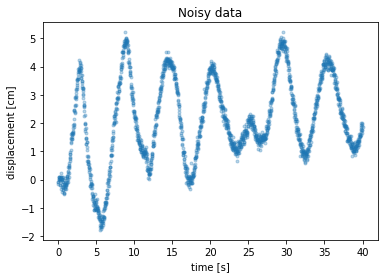

In [4]:
# Load data
data_noisy, variance_noise = load_synthetic_data(namefile=data_file)
time_vec = np.linspace(0., 0.02 * (len(data_noisy)-1), len(data_noisy))
            
# Visualize data time series
fig, ax = plt.subplots()
ax.plot(time_vec, data_noisy, linestyle='none', marker='.', alpha=0.3)
ax.set_title('Noisy data')
ax.set_xlabel('time [s]')
ax.set_ylabel('displacement [cm]')
plt.show()

### Define the InferenceModel object

It uses a RunModel object that defines the forward problem. For the Bayesian analysis, a prior must also be defined.

In [5]:
# Define the RunModel object
from UQpy.RunModel import RunModel
dyn_model = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_boucwen_RP', ntasks=4,
                     scale_factor=scale, var_names=var_names)

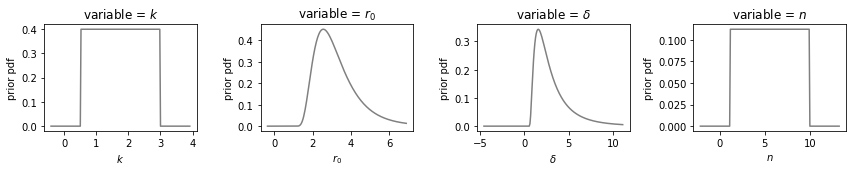

In [6]:
# Define a prior
from UQpy.Distributions import Distribution
prior_name = ['uniform', 'lognormal', 'lognormal', 'uniform']
prior_params = [[0.5, 2.5], [0.5, 1., 2], [0.8, 0.5, 2.], [1.1, 8.9]]
prior = Distribution(prior_name, params=prior_params)

fig, ax = plt.subplots(ncols=4, figsize=(12, 2.5))
for i, (var, name, params) in enumerate(zip(var_names, prior_name, prior_params)):
    p = Distribution(name)
    mean, std = p.moments(params)[0], np.sqrt(p.moments(params)[1])
    domain = np.linspace(mean - 3 * std, mean + 3 * std, 200).reshape((-1, 1))
    ax[i].plot(domain, p.pdf(x=domain, params=params), color='gray')
    ax[i].set_title('variable = '+var)
    ax[i].set_xlabel(var); ax[i].set_ylabel('prior pdf')
fig.tight_layout()
plt.savefig('parameters_prior.png')
plt.show()

In [7]:
# Define the InferenceModel
from UQpy.Inference import InferenceModel
inf_model_bw = InferenceModel(nparams=4, run_model_object=dyn_model, error_covariance=variance_noise, 
                              prior=prior, name='BoucWen')

### Maximum likelihood estimation using the Basin-Hopping optimization algorithm

To compute the maximum likelihood estimate of the parameters, one must minimize the negative log-likelihood $- \ln{p(\mathcal{D} \vert q)}$ (the prior is not utilized in ML estimation). By default, UQpy uses the minimize function of scipy.optimize but more advanced optimization algorithms can be used, as shown in this example where the global optimizer basin-hopping is used.

In [8]:
# Optimizer: basinhopping
from scipy.optimize import basinhopping

# Define lower and upper bounds as constraints for the optimizer
lower_bounds = np.array([0.5, 1., 0.55, 1.1])
upper_bounds = np.array([3., 6., 6., 8.])
constraints = {'type': 'ineq', 'fun': lambda x: np.concatenate([x-lower_bounds, upper_bounds-x], axis=0)}

In [9]:
# Instantiate the MLEstimation object
from UQpy.Inference import MLEstimation
ml_estimator = MLEstimation(inference_model=inf_model_bw, data=data_noisy,
                            optimizer=basinhopping, niter_success=10, minimizer_kwargs={'constraints': constraints})

In [10]:
# Run MLE and save to a file - starting point for the optimization: mean of the prior 
#x0, _, _, _ = prior.moments()
#ml_estimator.run_estimation(x0=x0)
#mle = ml_estimator.mle
#save_results(namefile=results_file, key='mle_basinhopping', value=mle)

# Load results file
mle = load_results(namefile=results_file, key='mle_basinhopping')

# Print MLE
print('Maximum likelihood parameter estimate:')
print(mle)

Maximum likelihood parameter estimate:
[0.99874635 2.65146818 1.03224395 2.65229712]


The user can run the forward problem with the ML estimate and compare to the noisy data.

In [11]:
# Run forward problem with MLE
dyn_model.run(samples=mle.reshape((1, 4)), append_samples=False)

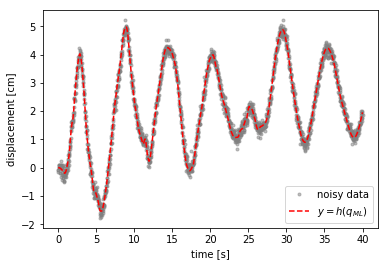

In [12]:
# Compare data with results from the MLEstimation
fig, ax = plt.subplots()
ax.plot(time_vec, data_noisy, color='grey', linestyle='none', marker='.', alpha=0.5, label='noisy data')
ax.plot(time_vec, dyn_model.qoi_list[0], label='$y=h(q_{ML})$', color='red', linestyle='--')
ax.set_xlabel('time [s]')
ax.set_ylabel('displacement [cm]')
plt.legend()
plt.show()

### Bayesian estimation using MCMC and the Stretch algorithm

Use an ensemble size of 16 samples, initially sampled around the mle.

In [13]:
seed = Distribution(['normal'] * 4, params=[[mle_i, 0.05 * mle_i] for mle_i in mle]).rvs(nsamples=16)

In [14]:
# Instantiate the BayesParameterEstimation object
from UQpy.Inference import BayesParameterEstimation
be = BayesParameterEstimation(data=data_noisy, inference_model=inf_model_bw, sampling_method='MCMC', 
                              seed=seed, algorithm='Stretch', scale=2.)

In [15]:
# Run estimation and save to file
#for nsamples in [5000, 5000, 5000]:
#    be.run_estimation(nsamples=nsamples)
#    save_results(namefile=results_file, key='mcmc_stretch', value=be.sampler.samples)

mcmc_samples = load_results(namefile=results_file, key='mcmc_stretch')

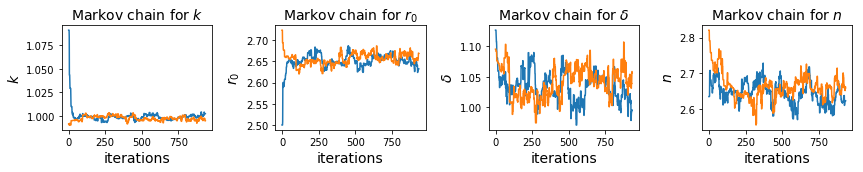

In [16]:
# Plot a couple of chains
unconcat_samples = mcmc_samples.reshape((-1, 16, 4))
fig, ax = plt.subplots(ncols=4, figsize=(12, 2.5))
for i, param_name in enumerate(var_names):
    ax[i].plot(unconcat_samples[:, 0, i])
    ax[i].plot(unconcat_samples[:, -1, i])
    ax[i].set_title('Markov chain for '+param_name, fontsize=14)
    ax[i].set_xlabel('iterations', fontsize=14)
    ax[i].set_ylabel(param_name, fontsize=14)
fig.tight_layout()
plt.show()

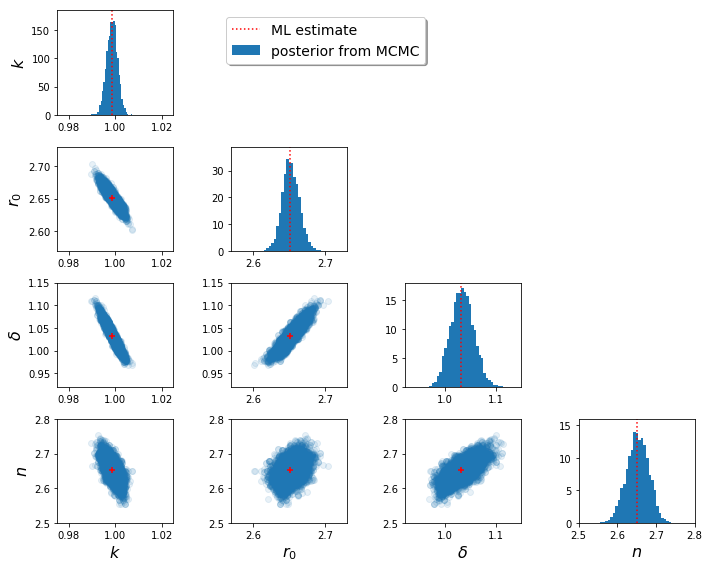

In [19]:
# Plot the posterior samples
unconcat_samples = mcmc_samples.reshape((-1, 16, 4))
nburn, jump = 150, 2
post_samples = unconcat_samples[nburn::jump].reshape((-1, 4))

domains = [[0.975, 1.025], [2.57, 2.73], [0.92, 1.15], [2.5, 2.8]]
heights = [185., 39., 18., 16.]
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 8))
for i, param_name in enumerate(var_names):
    ax[i, i].hist(post_samples[:, i], density=True, bins=30, label='posterior from MCMC')
    ax[i, i].plot([mle[i], mle[i]], [0., heights[i]], color='red', linestyle=':', label='ML estimate')
    ax[i, i].set_xlim(domains[i])
    ax[i, i].set_ylim([0., heights[i]])
    for j in range(i):
        ax[i, j].scatter(post_samples[:, j], post_samples[:, i], alpha=0.1, label='posterior from MCMC')
        ax[i, j].scatter(mle[j], mle[i], marker='+', color='red', label='ML estimate')
        ax[i, j].set_xlim(domains[j])
        ax[i, j].set_ylim(domains[i])
    for j in range(4):
        if i == 3:
            ax[i, j].set_xlabel(var_names[j], fontsize=16)
        if j == 0:
            ax[i, j].set_ylabel(var_names[i], fontsize=16)
        if i == 0 and j == 0:
            ax[i, j].legend(bbox_to_anchor=(1.4, 1.0), ncol=1, fancybox=True, shadow=True, fontsize=14)
    for j in range(i+1, 4):
        ax[i, j].axis('off')
fig.tight_layout()
plt.savefig('parameter_estimation.png')
plt.show()